# Bank Transaction Classifier
## Model Tuning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

# Area Under the Precision-Recall Curve 
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import f1_score, auc, average_precision_score

### Import data

In [2]:
%%time

# import training and test data
PATH_train = (r'assets\santander\train_clean.csv')
PATH_test = (r'assets\santander\test_clean.csv')

train_data = pd.read_csv(PATH_train, index_col=0)
test_data = pd.read_csv(PATH_test, index_col=0)

df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

display(df_train.head())

,target,0,1,2,3,4,5,6,7,8,...,103,104,105,106,107,108,109,110,111,112
0,0,-0.030036,0.189206,-0.142440,-0.143565,-0.151003,0.048416,-0.006850,0.524275,-0.027437,...,0.049008,-0.105020,0.121585,-0.095700,-0.204164,-0.001877,-0.050741,0.139615,-0.158355,0.029863
1,0,0.106808,0.214185,0.110886,-0.330231,0.198607,0.066315,-0.007137,0.271827,0.035643,...,0.256393,0.002263,0.338595,-0.165596,0.119298,-0.018020,0.046759,-0.013597,0.114231,0.122277
2,0,0.076225,0.235300,-0.076227,-0.116202,-0.269336,0.047058,0.084512,0.128066,0.001696,...,-0.040279,0.115815,-0.076621,0.107429,-0.189526,-0.000845,-0.062543,-0.073197,-0.077206,0.085458
3,0,0.048793,0.238961,0.462174,-0.136540,0.150583,0.044177,-0.094569,-0.232034,-0.064521,...,0.123483,-0.145394,-0.072105,-0.174420,-0.030363,-0.003602,-0.068549,0.031388,0.084580,0.154636
4,0,0.023979,-0.271960,-0.424338,0.035767,-0.105605,-0.058718,-0.118066,0.027984,0.016761,...,0.035982,0.016627,0.117125,-0.109610,-0.110014,-0.324441,0.008335,0.083176,-0.084813,0.022294


Wall time: 8min 24s


### Reduce memory usage

In [3]:
%%time

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 315.68 MB
Memory usage after optimization is: 80.64 MB
Decreased by 74.5%
Memory usage of dataframe is 173.95 MB
Memory usage after optimization is: 44.63 MB
Decreased by 74.3%
Wall time: 20.4 s


In [4]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

#
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Train, test, split

In [5]:
#
#data = df_train.drop('target', axis=1)
#target = df_train['target']
#features = [c for c in data.columns]
#
#X_train = data
#y_train = target
#X_test = df_test
#y_test = pd.DataFrame()

In [6]:
#
data = df_train.drop('target', axis=1)
target = df_train['target']
features = [c for c in data.columns]
#
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42)

## Hyperparameter Optimization

### Sample dataset
Sample 50% of training data for model optimization.

In [7]:
# sample training data
from sklearn.model_selection import train_test_split
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_train, y_train, test_size=0.5, random_state=42, stratify=y_train)

In [ ]:
#
#feature_fraction=0.05 # select portion of features
#colsample_bytree=feature_fraction
lambda_l1=0
lambda_l2=0
reg_alpha=lambda_l1
reg_lambda=lambda_l2
early_stopping_rounds=3000
valid_sets=[(X_train_sample,y_train_sample)]
eval_names=['valid']
boosting='gbdt'
metric='auc'
objective='binary'
num_threads=4
tree_learner='serial'

fit_params={'lambda_l1':lambda_l1,
            'lambda_l2':lambda_l2,
            #'early_stopping_rounds':early_stopping_rounds,
            #'valid_sets': valid_sets,
            #'eval_names': eval_names,
            'boosting':boosting,
            'metric':metric,
            'objective':objective,
            'num_threads':num_threads,
            'tree_learner':tree_learner
           }
# Initialize model.
from lightgbm import LGBMClassifier
model = LGBMClassifier(**fit_params, random_state=42)

In [ ]:
%%time
model.fit(X_train_sample, y_train_sample)

In [ ]:
%%time

# define our parameter ranges
n_estimators=[int(x) for x in np.linspace(start = 100, stop = 1000, num = 3)]
bagging_freq=[0,5]
bagging_fraction=[x for x in np.linspace(.25, 1, num = 3)]
subsample=bagging_fraction
max_bin=[int(x) for x in np.linspace((255/2), 255, num = 3)]
num_leaves=[int(x) for x in np.linspace(start = 13, stop = 62, num = 3)]
max_depth=[int(x) for x in np.linspace(start = 3, stop = 15, num = 4)]
max_depth.append(-1)
min_data_in_leaf=[20, 80, 160]
min_sum_hessian_in_leaf=[1e-5, 1e-3, 1e-1, 1, 10]
min_child_weight=min_sum_hessian_in_leaf
verbose=[1,1000]
boost_from_average=[True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
              'bagging_freq': bagging_freq,
              'bagging_fraction': bagging_fraction,
              'max_bin': max_bin,
              'num_leaves': num_leaves,
              'max_depth': max_depth,
              'min_data_in_leaf': min_data_in_leaf,
              'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
              'verbose': verbose,
              #'boost_from_average': boost_from_average
             }
print(param_grid)
# fit model
from sklearn.model_selection import RandomizedSearchCV
model = RandomizedSearchCV(model, param_grid, cv=3)
model.fit(X_train_sample, y_train_sample)
# get the best parameters
best_params = model.best_params_
print(best_params)

In [8]:
# hard code optimized parameters
best_params = {'verbose': 1,
               'num_leaves': 37,
               'n_estimators': 1000,
               'min_sum_hessian_in_leaf': 10,
               'min_data_in_leaf': 20,
               'max_depth': 11,
               'max_bin': 191,
               'bagging_freq': 0,
               'bagging_fraction': 0.625}

## Final Model

In [12]:
%%time

# refit model with best parameters
model_best = LGBMClassifier(**best_params, random_state=42)
# Train the classifier 
model_best.fit(X_train, y_train)
# Test the classifier and get the prediction
y_pred = model_best.predict(X_test)
# metrics
model_metrics = {}
model_metrics['Accuracy score'] = accuracy_score(y_test, y_pred)
model_metrics['Mean absolute error'] = mean_absolute_error(y_test, y_pred)
model_metrics['Mean squared error'] = mean_squared_error(y_test, y_pred)

Wall time: 2min 31s


### Confusion matrix

Recall metric in the train dataset: 96.46428869072423%
Precision metric in the train dataset: 96.4338000938658%


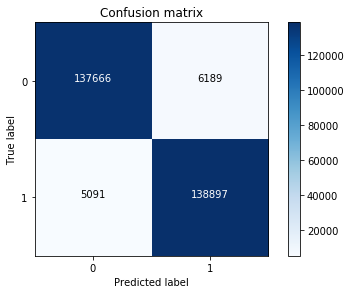

In [13]:
y_pred_train = model_best.predict(X_train)
cnf_matrix = confusion_matrix(y_train, y_pred_train)

model_metrics['Train Recall metric'] = 100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
print("Recall metric in the train dataset: {}%".format(model_metrics['Train Recall metric'])
     )
model_metrics['Train Precision metric'] = 100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])
print("Precision metric in the train dataset: {}%".format(model_metrics['Train Precision metric'])
     )
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.savefig('assets\opt_conf_train.png')
plt.show()

Recall metric in the test dataset: 91.1761430082976%
Precision metric in the test dataset: 91.06971763512371%


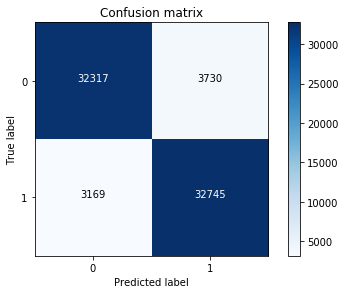

In [14]:
cnf_matrix = confusion_matrix(y_test, y_pred)

model_metrics['Test Recall metric'] = 100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
print("Recall metric in the test dataset: {}%".format(model_metrics['Test Recall metric'])
     )
model_metrics['Test Precision metric'] = 100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])
print("Precision metric in the test dataset: {}%".format(model_metrics['Test Precision metric'])
     )
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.savefig('assets\opt_conf_test.png')
plt.show()

### ROC curve

ROC-AUC: 0.904


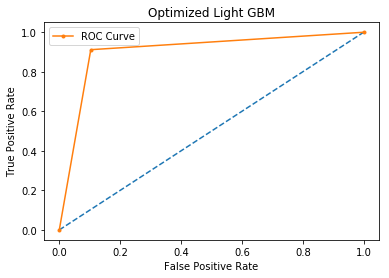

In [15]:
# calculate AUC
model_metrics['ROC-AUC'] = auc_score = roc_auc_score(y_test, y_pred)
print('ROC-AUC: %.3f' % model_metrics['ROC-AUC'])
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='ROC Curve')
plt.title('Optimized Light GBM')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.savefig('assets\opt_roc.png')
plt.show()

### Precision-recall curve

f1=0.905 auc=0.927 ap=0.863


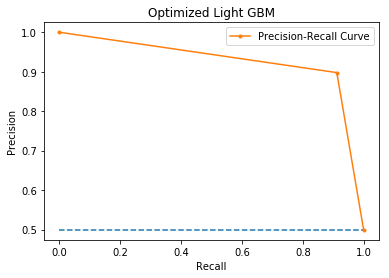

In [16]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# calculate F1 score
model_metrics['F1 score'] = f1_score(y_test, y_pred)
# calculate precision-recall AUC
model_metrics['Precision-Recall AUC'] = auc(recall, precision)
# calculate average precision score
model_metrics['Average Precision'] = average_precision_score(y_test, y_pred)
print('f1=%.3f auc=%.3f ap=%.3f' % (model_metrics['F1 score'],
                                    model_metrics['Precision-Recall AUC'],
                                    model_metrics['Average Precision']))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Optimized Light GBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.savefig('assets\opt_recall-precision.png')
plt.show()

### Metrics

In [17]:
# view metrics
print('Optimized Light GBM')
for i in model_metrics.items():
    print(i)

Optimized Light GBM
('Accuracy score', 0.9041286252275538)
('Mean absolute error', 0.09587137477244619)
('Mean squared error', 0.09587137477244619)
('Train Recall metric', 96.46428869072423)
('Train Precision metric', 96.4338000938658)
('Test Recall metric', 91.1761430082976)
('Test Precision metric', 91.06971763512371)
('ROC-AUC', 0.9041427063306382)
('F1 score', 0.9046954647805606)
('Precision-Recall AUC', 0.926768674791295)
('Average Precision', 0.8625607866159142)


In [27]:
old_mets = [0.8377593418657329,
0.16224065813426716,
0.16224065813426716,
85.2848848515154,
85.25108243188684,
83.88372222531603,
83.898965171915,
0.8377613303542552,
0.837682650465055,
0.8779004656629318,
0.7821460087311239]

new_mets = [0.9041286252275538,
0.09587137477244619,
0.09587137477244619,
96.46428869072423,
96.4338000938658,
91.1761430082976,
91.06971763512371,
0.9041427063306382,
0.9046954647805606,
0.926768674791295,
0.8625607866159142]

idx=0
mets = []
for i in new_mets:
    mets.append(new_mets[idx]-old_mets[idx])
    idx+=1

mets = [i*100 for i in mets]
mets

[6.636928336182091,
 -6.636928336182097,
 -6.636928336182097,
 1117.940383920883,
 1118.2717661978954,
 729.2420782981566,
 717.0752463208714,
 6.6381375976383055,
 6.701281431550566,
 4.8868209128363205,
 8.041477788479023]